In [8]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Preprocess the data
hr = pd.read_csv('./data/xml_export/HeartRate.csv', low_memory=False)[["startDate", "endDate", "value"]]
hrv = pd.read_csv('./data/xml_export/HeartRateVariabilitySDNN.csv', low_memory=False)[["startDate", "endDate", "value"]]
sleep = pd.read_csv('./data/train_detailed.csv', low_memory=False)[["startDate", "endDate", "value"]]

sleep['value'] = sleep['value'].replace({"HKCategoryValueSleepAnalysisInBed": 0.5, "HKCategoryValueSleepAnalysisAsleepUnspecified" : 1.0}) # Replace values in sleep
sleep.rename(columns={'value': 'sleep_prob'}, inplace=True) # Rename sleep value column

# Convert date columns to datetime objects
hr['startDate'] = pd.to_datetime(hr['startDate'])
hrv['startDate'] = pd.to_datetime(hrv['startDate'])
sleep['startDate'] = pd.to_datetime(sleep['startDate'])
sleep['endDate'] = pd.to_datetime(sleep['endDate'])

# Filter all data > 2020-09-25 and < 2022-01-01
hr = hr[hr['startDate'] > '2020-09-25']
hr = hr[hr['endDate'] < '2022-01-01']

hrv = hrv[hrv['startDate'] > '2020-09-25']
hrv = hrv[hrv['endDate'] < '2022-01-01']

sleep = sleep[sleep['startDate'] > '2020-09-25']
sleep = sleep[sleep['endDate'] < '2022-01-01']

# Resample the data to a consistent time interval (minute)
mins = 5

hr.set_index('startDate', inplace=True)
hrv.set_index('startDate', inplace=True)
hr = hr.resample(f'{mins}T').mean(numeric_only = True).ffill().reset_index()
hrv = hrv.resample(f'{mins}T').mean(numeric_only = True).ffill().reset_index()

# Merge the dataframes on the common datetime index
merged_data = pd.merge(hr, hrv, on='startDate', how='outer', suffixes=('_hr', '_hrv'))
merged_data.set_index('startDate', inplace=True)

# Ensure both DataFrames are sorted by the timestamp
merged_data = merged_data.sort_index()

# Sort sleep intervals and remove duplicates
sleep = sleep.sort_values('startDate').reset_index(drop=True)

# Create a list of sleep interval tuples and corresponding sleep probabilities
sleep_intervals = [(row['startDate'], row['endDate']) for _, row in sleep.iterrows()]

# Create a boolean array with the same length as merged_data
sleep_prob_arr = np.zeros(len(merged_data), dtype=float)

# Assign sleep probabilities to the boolean array
for idx, row in sleep.iterrows():
    mask = (merged_data.index >= row['startDate']) & (merged_data.index < row['endDate'])
    sleep_prob_arr[mask] = row['sleep_prob']

# Assign the sleep_prob_arr to merged_data
merged_data['sleep_prob'] = sleep_prob_arr

print(merged_data.shape)

(133103, 3)


In [17]:
print(merged_data['sleep_prob'].value_counts(normalize=True))

0.0    0.661097
1.0    0.275471
0.5    0.063432
Name: sleepProbability, dtype: float64


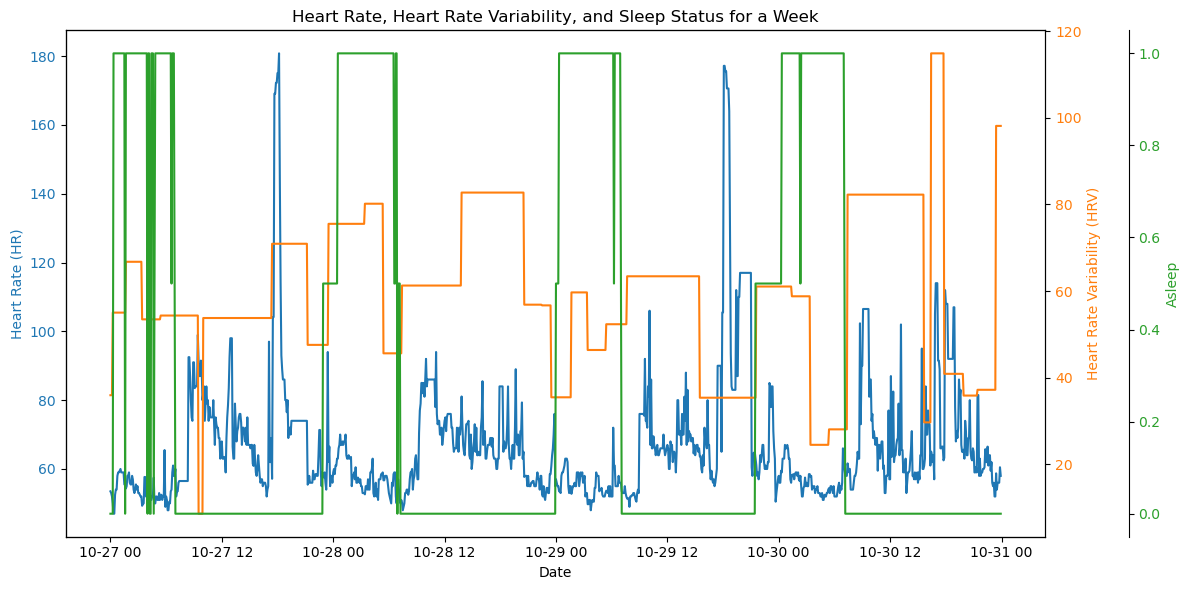

In [10]:
import matplotlib.pyplot as plt

# Define the start and end date for the week you want to plot
start_date = '2020-10-27'  # Replace with the start date of the week you want to plot
end_date = '2020-10-30'    # Replace with the end date of the week you want to plot

# Filter the data for the specified week
week_data = merged_data.loc[start_date:end_date]

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Heart Rate (HR)', color='tab:blue')
ax1.plot(week_data.index, week_data['value_hr'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Heart Rate Variability (HRV)', color='tab:orange')
ax2.plot(week_data.index, week_data['value_hrv'], color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax3 = ax1.twinx()
ax3.set_ylabel('Asleep', color='tab:green')
ax3.plot(week_data.index, week_data['sleep_prob'], color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')
ax3.spines['right'].set_position(('outward', 60)) # Shift the position of the third y-axis

plt.title('Heart Rate, Heart Rate Variability, and Sleep Status for a Week')
fig.tight_layout()
plt.show()

In [11]:
merged_data.reset_index().head()

,startDate,value_hr,value_hrv,sleepProbability
0,2020-09-25 20:00:00-04:00,58.000000,NaN,0.0
1,2020-09-25 20:05:00-04:00,58.000000,NaN,0.0
2,2020-09-25 20:10:00-04:00,60.333333,59.7688,0.0
3,2020-09-25 20:15:00-04:00,59.002300,97.5801,0.0
4,2020-09-25 20:20:00-04:00,65.666667,97.5801,0.0


In [16]:
# Create a new column that represents the date considering the 12 PM to 12 PM interval
noon = pd.to_datetime('12:00:00').time()
merged_data['adjusted_date'] = merged_data.index.date
mask = merged_data.index.time < noon
merged_data.loc[mask, 'adjusted_date'] -= pd.Timedelta(days=1)

# Group the data by the adjusted_date column
grouped_data = merged_data.groupby('adjusted_date')

# Calculate the sum of sleep probabilities within each group and convert it to sleep hours
sleep_hours = grouped_data['sleep_prob'].sum() * (mins / 60)

# Reset the index and rename the columns
sleep_hours = sleep_hours.reset_index().rename(columns={'adjusted_date': 'date', 'sleep_prob': 'sleep_hours'})

print(sleep_hours)


           date  sleep_hours
0    2020-09-25     0.000000
1    2020-09-26     7.291667
2    2020-09-27     8.125000
3    2020-09-28     7.125000
4    2020-09-29     8.125000
..          ...          ...
458  2021-12-27     3.041667
459  2021-12-28     4.166667
460  2021-12-29     7.041667
461  2021-12-30     6.083333
462  2021-12-31     0.000000

[463 rows x 2 columns]


7.541667    0.028078
7.666667    0.028078
7.291667    0.025918
7.375000    0.025918
7.708333    0.025918
              ...   
4.208333    0.002160
5.041667    0.002160
5.375000    0.002160
5.458333    0.002160
4.166667    0.002160
Name: sleep_hours, Length: 107, dtype: float64

In [34]:
def preprocess_data(input_data_files, sleep_data_file, start_date='2020-09-25', end_date='2022-01-01', resample_minutes=5):
    sleep = pd.read_csv(sleep_data_file, low_memory=False)[["startDate", "endDate", "value"]]
    sleep['value'] = sleep['value'].replace({"HKCategoryValueSleepAnalysisInBed": 0.5, "HKCategoryValueSleepAnalysisAsleepUnspecified" : 1.0})
    sleep.rename(columns={'value': 'sleep_prob'}, inplace=True)
    sleep['startDate'] = pd.to_datetime(sleep['startDate'])
    sleep['endDate'] = pd.to_datetime(sleep['endDate'])
    sleep = sleep[(sleep['startDate'] > start_date) & (sleep['endDate'] < end_date)]

    merged_data = None
    for input_file, suffix in input_data_files:
        input_data = pd.read_csv(input_file, low_memory=False)[["startDate", "endDate", "value"]]
        input_data['startDate'] = pd.to_datetime(input_data['startDate'])
        input_data = input_data[(input_data['startDate'] > start_date) & (input_data['endDate'] < end_date)]
        input_data.set_index('startDate', inplace=True)
        input_data = input_data.resample(f'{resample_minutes}T').mean(numeric_only=True).ffill().reset_index()
        input_data.rename(columns={'value': suffix}, inplace=True)

        if merged_data is None:
            merged_data = input_data
        else:
            merged_data = pd.merge(merged_data, input_data, on='startDate', how='outer')

    merged_data.set_index('startDate', inplace=True)
    merged_data = merged_data.sort_index()
    sleep = sleep.sort_values('startDate').reset_index(drop=True)
    sleep_intervals = [(row['startDate'], row['endDate']) for _, row in sleep.iterrows()]
    sleep_prob_arr = np.zeros(len(merged_data), dtype=float)

    for idx, row in sleep.iterrows():
        mask = (merged_data.index >= row['startDate']) & (merged_data.index < row['endDate'])
        sleep_prob_arr[mask] = row['sleep_prob']

    merged_data['sleep_prob'] = sleep_prob_arr
    
    merged_data = merged_data.reset_index()
    merged_data = merged_data.fillna(method='ffill').fillna(method='bfill')
    
    return merged_data

# Features to add: basal energy burned, flights climbed, step count, distance walk/run
input_data_files = [
    ('./data/xml_export/HeartRate.csv', 'hr'), 
    ('./data/xml_export/HeartRateVariabilitySDNN.csv', 'hrv'),
    ('./data/xml_export/BasalEnergyBurned.csv', 'basal_energy'),
    ('./data/xml_export/FlightsClimbed.csv', 'flights_climbed'),
    ('./data/xml_export/StepCount.csv', 'step_count'),
    ('./data/xml_export/DistanceWalkingRunning.csv', 'distance')
                    ]

data = preprocess_data(input_data_files, 'data/train_detailed.csv')

In [37]:
data = data.drop(columns = ['startDate'])

y = data['sleep_prob']
X = data.drop(columns = ['sleep_prob'])

split = 0.8
split_idx = int(len(X) * split)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]





,startDate,hr,hrv,basal_energy,flights_climbed,step_count,distance,sleep_prob
0,2020-09-25 08:10:00-04:00,NaN,NaN,NaN,NaN,13.0,0.006357,0.0
1,2020-09-25 08:15:00-04:00,NaN,NaN,NaN,NaN,13.0,0.006357,0.0
2,2020-09-25 08:20:00-04:00,NaN,NaN,NaN,NaN,13.0,0.006357,0.0
3,2020-09-25 08:25:00-04:00,NaN,NaN,NaN,NaN,13.0,0.006357,0.0
4,2020-09-25 08:30:00-04:00,NaN,NaN,NaN,NaN,13.0,0.006357,0.0
...,...,...,...,...,...,...,...,...
133240,2021-12-31 23:30:00-04:00,67.0,NaN,19.166,NaN,25.0,0.011041,0.0
133241,2021-12-31 23:35:00-04:00,67.0,NaN,NaN,NaN,25.0,0.011041,0.0
133242,2021-12-31 23:40:00-04:00,70.0,NaN,NaN,NaN,25.0,0.011041,0.0
133243,2021-12-31 23:45:00-04:00,70.0,NaN,NaN,NaN,10.0,0.005849,0.0


In [22]:
test

0.0    0.661097
1.0    0.275471
0.5    0.063432
Name: sleepProbability, dtype: float64
